# Extra task: uncertainty
Use Monte Carlo Dropout to estimate classification confidence. 
Compare dropout to an ensemble of CNN networks (e.g.: do individual dropout subnetworks point to the same, or different local minima?)

Great article to get familiar with the topic: [link](https://medium.com/@ciaranbench/monte-carlo-dropout-a-practical-guide-4b4dc18014b5).

In [17]:
import os

os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

# import matplotlib as mpl
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
from keras.api.utils import image_dataset_from_directory
import numpy as np
import tensorflow as tf
import keras
from keras.api.optimizers import SGD
from keras.api.callbacks import EarlyStopping, TensorBoard
from keras.api.optimizers.schedules import ExponentialDecay
from keras.api.losses import CategoricalCrossentropy
from keras.api.metrics import CategoricalAccuracy

DATA_PATH = os.path.join(os.getcwd(), "..", "data")
MODEL_PATH = os.path.join(os.getcwd(), "..", "models")
LOG_DIR = os.path.join(os.getcwd(), "..", "logs")

In [2]:
dataset_path = os.path.join(DATA_PATH, "kaggle-speech-recognition")
batch_size = 128
class_names = next(os.walk(os.path.join(dataset_path, "train")))[1]
class_dict = dict(zip(class_names, range(len(class_names))))

ds_train: tf.data.Dataset = image_dataset_from_directory(os.path.join(dataset_path, "train"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)
ds_valid: tf.data.Dataset  = image_dataset_from_directory(os.path.join(dataset_path, "validation"), color_mode="grayscale",
                                        label_mode="categorical", batch_size=batch_size, class_names=class_names,
                                        seed=42, validation_split=0.0)

ds_train = ds_train.prefetch(tf.data.AUTOTUNE)
ds_valid = ds_valid.prefetch(tf.data.AUTOTUNE)

Found 51088 files belonging to 30 classes.


I0000 00:00:1734099838.216230    3380 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 3586 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


Found 6798 files belonging to 30 classes.


The architecture of the model is AlexNet, since by convention it has dropout layers in the dense tail. Therefore it fits nicely with out goal here.

In [3]:
def model(
        normalization_layer = None,
        dropout_rate = 0.5,
        input_shape = (256, 256),
        batch_size = 128
):
    inputs = keras.layers.Input(shape=input_shape, batch_size=batch_size)

    # Preprocessing
    x = keras.layers.Reshape((*input_shape, 1))(inputs)
    if normalization_layer is not None:
        x = normalization_layer(x)
    x = keras.layers.RandomCrop(height=227, width=227)(x)

    # Convolutional layers
    # Instead of 11x11 stride 4 we are going to use subsequent 3x3 layers
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2)(x)
    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(128, kernel_size=(3, 3))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((3, 3), strides=(2, 2))(x)

    x = keras.layers.Conv2D(256, kernel_size=(2, 2), strides=2)(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.Conv2D(256, kernel_size=(2, 2))(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.MaxPool2D((2, 2), strides=(2, 2))(x)


    # Dense tail
    x = keras.layers.Flatten("channels_last")(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    x = keras.layers.Dense(256, activation="relu")(x)
    x = keras.layers.Dropout(rate=dropout_rate)(x)
    outputs = keras.layers.Dense(30, activation="softmax")(x)

    return keras.Model(inputs=inputs, outputs=outputs, name="MyAlexNet")

In [4]:
normalization_layer = keras.layers.Normalization(axis=-1)
feature_ds = ds_train.map(lambda x, y: x)
normalization_layer.adapt(feature_ds)
ensembles = [model(normalization_layer) for _ in range(5)]

2024-12-13 15:24:10.393212: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [5]:
def train(model: keras.Model, ds_train: tf.data.Dataset, ds_valid: tf.data.Dataset, ensemble_id: int):
    lr_scheduler = ExponentialDecay(0.01, decay_steps=10_000, decay_rate=0.9)
    optimizer = SGD(learning_rate=lr_scheduler, momentum=0.9)
    loss = CategoricalCrossentropy()
    model.compile(optimizer=optimizer, loss=loss,
                  metrics=[CategoricalAccuracy(name="categorical_accuracy")])

    early_stopping = EarlyStopping(patience=15, restore_best_weights=True, start_from_epoch=5)
    log_dir = os.path.join(LOG_DIR, "kaggle-speech-recognition", model.name)
    model_log_dir = os.path.join(log_dir, f"ensemble_{ensemble_id}")
    tensorboard_cb = TensorBoard(log_dir=model_log_dir, histogram_freq=1)
    model.fit(ds_train, validation_data=ds_valid, epochs=35, verbose=0,
              callbacks=[early_stopping, tensorboard_cb])
    return model

In [ ]:
ensembles = [train(model, ds_train, ds_valid, i) for i, model in enumerate(ensembles)]

Epoch 1/35


2024-12-12 19:32:21.994581: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907
W0000 00:00:1734028342.196645  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.397217  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.401961  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.406964  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.411005  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.415829  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.432114  130531 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028342.441758  130531 gpu_t

  1/400 ━━━━━━━━━━━━━━━━━━━━ 1:08:59 10s/step - categorical_accuracy: 0.0312 - loss: 4.7902

W0000 00:00:1734028349.681604  130532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028349.702888  130532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028349.721066  130532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028349.730296  130532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028349.740621  130532 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced


399/400 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step - categorical_accuracy: 0.0439 - loss: 3.4639

W0000 00:00:1734028438.062892  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.064747  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.066427  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.067947  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.069817  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.071404  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.073498  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.075547  130529 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028438.077582  130529 gp

400/400 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - categorical_accuracy: 0.0439 - loss: 3.4637

W0000 00:00:1734028442.437602  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.440271  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.442977  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.446166  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.449456  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.452925  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.455863  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.458536  130526 gpu_timer.cc:114] Skipping the delay kernel, measurement accuracy will be reduced
W0000 00:00:1734028442.461631  130526 gp

400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 252ms/step - categorical_accuracy: 0.0440 - loss: 3.4634 - val_categorical_accuracy: 0.0880 - val_loss: 3.2855
Epoch 2/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 108s 270ms/step - categorical_accuracy: 0.0824 - loss: 3.2396 - val_categorical_accuracy: 0.0800 - val_loss: 3.3156
Epoch 3/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 111s 278ms/step - categorical_accuracy: 0.1570 - loss: 2.8584 - val_categorical_accuracy: 0.2298 - val_loss: 2.7291
Epoch 4/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 112s 279ms/step - categorical_accuracy: 0.2572 - loss: 2.4257 - val_categorical_accuracy: 0.3370 - val_loss: 2.3162
Epoch 5/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 112s 279ms/step - categorical_accuracy: 0.3606 - loss: 2.0618 - val_categorical_accuracy: 0.5026 - val_loss: 1.6972
Epoch 6/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 115s 289ms/step - categorical_accuracy: 0.4401 - loss: 1.7807 - val_categorical_accuracy: 0.5138 - val_loss: 1.6260
Epoch 7/35
400/400 ━━━━━━━━━━━━━━━━━━━━ 112s 281ms/step - categorical_accur

In [14]:
def predict_mc_dropout(model: keras.Model, x: np.ndarray, sample=20):
    y_hat_arr = []
    for _ in range(sample):
        y_hat = model(x, training=True).numpy()
        y_hat_arr.append(y_hat)

    y_hat_arr = tf.stack(y_hat_arr, axis=0)
    y_probs = tf.reduce_mean(y_hat_arr, axis=0)

    return y_probs

x, y = next(ds_valid.take(1).as_numpy_iterator())
predict_mc_dropout(ensembles[0], x)

<tf.Tensor: shape=(128, 30), dtype=float32, numpy=
array([[0.0238649 , 0.00712674, 0.00676728, ..., 0.03654487, 0.01506905,
        0.0186868 ],
       [0.02247801, 0.01001897, 0.02143752, ..., 0.05709901, 0.01496664,
        0.0178852 ],
       [0.05533819, 0.0022595 , 0.02204206, ..., 0.00631825, 0.00442941,
        0.04627362],
       ...,
       [0.02862909, 0.00423215, 0.00927176, ..., 0.00712926, 0.01805998,
        0.05233157],
       [0.03320304, 0.00153961, 0.01672831, ..., 0.0499891 , 0.00864838,
        0.03518165],
       [0.04800142, 0.00497067, 0.01245013, ..., 0.02672917, 0.0059528 ,
        0.02306368]], dtype=float32)>

In [18]:
def multiclass_calibration_curve(probs: np.ndarray, labels: np.ndarray, bins: int):
    edges = np.linspace(0.0, 1.0, bins + 1, dtype=np.float32)

    midpoints = []
    accuracies = []
    mean_confidences = []

    for i in range(bins):
        start = edges[i]
        end = edges[i + 1]
        midpoint = (start + end) / 2

        mask = (probs >= start) & (probs < end)
        count = mask.sum()
        accuracy = labels[mask].sum() / count
        mean_confidence = probs[mask].mean()

        midpoints.append(midpoint)
        accuracies.append(accuracy)
        mean_confidences.append(mean_confidence)

    return midpoints, accuracies, mean_confidences


def plot_multiclass_calibration_curve(probs, labels, bins=10, title=None):
    if title is None:
        title = "Reliability diagram"

    midpoints, accuracies, mean_confidences = multiclass_calibration_curve(probs, labels, bins=bins)
    plt.bar(midpoints, accuracies, width=1.0/float(bins), align='center', lw=1, ec='#000000', fc='#2233aa', alpha=1, label='Model', zorder=0)
    plt.scatter(midpoints, accuracies, lw=2, ec='black', fc="#ffffff", zorder=2)
    plt.plot(np.linspace(0, 1.0, 20), np.linspace(0, 1.0, 20), '--', lw=2, alpha=.7, color='gray', label='Perfectly calibrated', zorder=1)
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.0)
    plt.xlabel('\nconfidence')
    plt.ylabel('accuracy\n')
    plt.title(title+'\n')
    plt.xticks(midpoints, rotation=-45)
    plt.legend(loc='upper left')
    return midpoints, accuracies, mean_confidences

In [21]:
xd = predict_mc_dropout(ensembles[0], x)
xd

TensorShape([128, 30])

/tmp/ipykernel_3380/783633005.py:15: RuntimeWarning: invalid value encountered in divide
  accuracy = labels[mask].sum() / count
/tmp/ipykernel_3380/783633005.py:16: RuntimeWarning: Mean of empty slice.
  mean_confidence = probs[mask].mean()
/home/kaszkiet/projects/IML_Voice_Recognition/.venv/lib/python3.12/site-packages/numpy/_core/_methods.py:138: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


([np.float32(0.05),
  np.float32(0.15),
  np.float32(0.25),
  np.float32(0.35000002),
  np.float32(0.45),
  np.float32(0.55),
  np.float32(0.65),
  np.float32(0.75),
  np.float32(0.85),
  np.float32(0.95)],
 [np.float64(0.03341618337475835),
  np.float64(0.02926829268292683),
  np.float64(0.07692307692307693),
  np.float64(0.0),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan),
  np.float64(nan)],
 [np.float32(0.027062712),
  np.float32(0.13080455),
  np.float32(0.22163197),
  np.float32(0.30976444),
  np.float32(nan),
  np.float32(nan),
  np.float32(nan),
  np.float32(nan),
  np.float32(nan),
  np.float32(nan)])

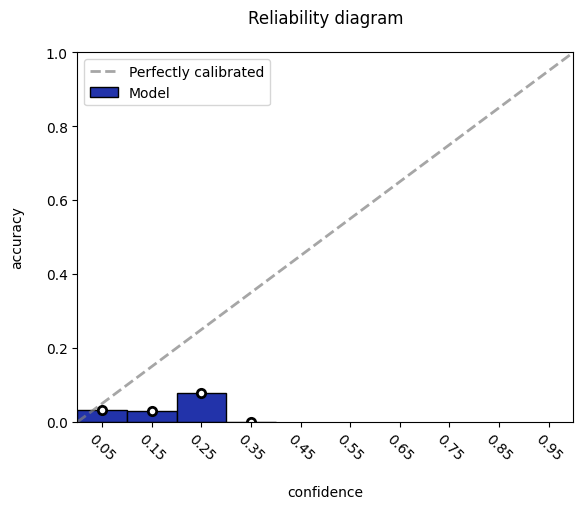

In [22]:
plot_multiclass_calibration_curve(xd.numpy(), y)